# Train on GPU with vectorized mini-batch SGD

This notebook is part of article [Explaining RNNs without neural networks](https://explained.ai/rnn/index.html) and notebook [prep.ipynb](prep.ipynb) should be run before this notebook as it needs files: `data/X.pkl` and `data/y.pkl`.

## Load X, y

In [1]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)
from typing import Sequence

!if ! test -f support.py; then wget https://raw.githubusercontent.com/parrt/ml-articles/master/rnn/notebooks/support.py; fi

from support import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
import pickle
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)
with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

## Split out validation set

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)

In [5]:
def get_max_len(X):
    max_len = 0
    for x in X:
        max_len = max(max_len, len(x))
    return max_len

In [6]:
def onehot_matrix(X, max_len, vocab, verbose=False):
    X_onehot = torch.zeros((len(X),max_len,len(vocab)), dtype=torch.float64)
    for i,x in enumerate(X):
        pad = max_len - len(x)
        for j,c in enumerate(x):
            X_onehot[i, j+pad, ctoi[c]] = 1
        if verbose: print(x); print(X_onehot[i].T, "\n")
    return X_onehot.to(device)

In [7]:
def forward(X_onehot, max_len:int, vocab:dict):
    "Cut-n-paste from body of training for use with metrics"
    H = torch.zeros(nhidden, len(X_onehot), device=device, dtype=torch.float64, requires_grad=False)
    for j in range(max_len):
        x_step_t = X_onehot[:,j].T
        H = W.mm(H) + U.mm(x_step_t)
        H = torch.tanh(H)        
    o = V.mm(H)
    o = o.T # make it batch_size x nclasses
    o = softmax(o)
    return o

## Setup

Just some matrices. First, set up hyper parameters:

In [8]:
y_train = torch.tensor(y_train, dtype=torch.long) # keep these on the CPU
y_valid = torch.tensor(y_valid, dtype=torch.long)

In [9]:
vocab, ctoi = getvocab(X)

In [10]:
nhidden = 100
batch_size = 32

n = len(X_train)

nbatches = n // batch_size
n = nbatches * batch_size
X_train = X_train[0:n]
y_train = y_train[0:n]
vocab, ctoi = getvocab(X)
max_len = get_max_len(X)
nfeatures = len(vocab)
nclasses = len(torch.unique(y_train))

print(f"{n:,d} training records, batch size {batch_size}, {nfeatures} features (chars), {nclasses} target languages, state is {nhidden}-vector")

10,688 training records, batch size 32, 29 features (chars), 18 target languages, state is 100-vector


## Train using pure SGD, one record used to compute gradient

Epoch:   1 accum loss  1.9714 accur 0.597 | train loss  1.1566 accur 0.674 | valid loss  1.3000 accur 0.655
Epoch:   2 accum loss  1.1729 accur 0.673 | train loss  0.9960 accur 0.697 | valid loss  1.1791 accur 0.666
Epoch:   3 accum loss  1.0144 accur 0.714 | train loss  0.9353 accur 0.733 | valid loss  1.1374 accur 0.707
Epoch:   4 accum loss  0.9206 accur 0.735 | train loss  0.8983 accur 0.740 | valid loss  1.1109 accur 0.700
Epoch:   5 accum loss  0.8785 accur 0.740 | train loss  0.8887 accur 0.734 | valid loss  1.1108 accur 0.693
Epoch:   6 accum loss  0.8275 accur 0.755 | train loss  0.7861 accur 0.768 | valid loss  1.0469 accur 0.721
Epoch:   7 accum loss  0.8172 accur 0.759 | train loss  0.7643 accur 0.770 | valid loss  1.0405 accur 0.722
Epoch:   8 accum loss  0.7823 accur 0.769 | train loss  0.8170 accur 0.751 | valid loss  1.1112 accur 0.704
Epoch:   9 accum loss  0.7583 accur 0.773 | train loss  0.7415 accur 0.783 | valid loss  1.0672 accur 0.735
Epoch:  10 accum loss  0.741

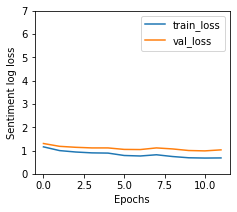

CPU times: user 22.8 s, sys: 1.47 s, total: 24.3 s
Wall time: 20.8 s


In [11]:
%%time 
#torch.manual_seed(0) # SET SEED FOR TESTING
W = torch.eye(nhidden,    nhidden,   device=device, dtype=torch.float64, requires_grad=True)
U = torch.randn(nhidden,  nfeatures, device=device, dtype=torch.float64, requires_grad=True) # embed one-hot char vec
V = torch.randn(nclasses, nhidden,   device=device, dtype=torch.float64, requires_grad=True) # take RNN output (h) and predict target

# Let's compute the big 3D one hot matrix for all examples so we don't re-create
# four batches all the time; might push data back and forth between CPU and GPU
X_train_onehot = onehot_matrix(X_train, max_len, vocab)
X_valid_onehot = onehot_matrix(X_valid, max_len, vocab)

optimizer = torch.optim.Adam([W,U,V], lr=0.005, weight_decay=0.0)

history = []
epochs = 12
for epoch in range(1, epochs+1):
#     print(f"EPOCH {epoch}")
    epoch_training_loss = 0.0
    epoch_training_accur = 0.0
    total = 0
    for p in range(0, n, batch_size):  # do one epoch
        loss = 0
        batch_X = X_train_onehot[p:p+batch_size]
        batch_y = y_train[p:p+batch_size]
        H = torch.zeros(nhidden, batch_size, device=device, dtype=torch.float64, requires_grad=False)
        for t in range(max_len):
            x_step_t = batch_X[:,t].T # make it len(vocab) x batch_size
            H = W.mm(H) + U.mm(x_step_t)
            H = torch.tanh(H)
        o = V.mm(H)
        o = o.T # make it batch_size x nclasses
        o = softmax(o)
        loss = cross_entropy(o, batch_y)
#         print(loss.item())
        correct = torch.argmax(o, dim=1).detach().cpu()==batch_y
        epoch_training_accur += torch.sum(correct)
        total += len(batch_y)

        # update matrices based upon loss computed from a batch
        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad, M.grad, ...
        optimizer.step()

        epoch_training_loss += loss.detach().item()

    epoch_training_loss /= nbatches
    epoch_training_accur /= n
#     print(f"Epoch {epoch:3d} training loss {epoch_training_loss:7.4f} accur {epoch_training_accur:7.4f}")

    with torch.no_grad():
        o = forward(X_train_onehot, max_len, vocab)#, apply_softmax=False)
        train_loss = cross_entropy(o, y_train).item()
        correct = torch.argmax(o, dim=1).detach().cpu()==y_train
        train_accur = torch.sum(correct) / float(len(X_train))

        o = forward(X_valid_onehot, max_len, vocab)
        valid_loss = cross_entropy(o, y_valid).item()
        correct = torch.argmax(o, dim=1).detach().cpu()==y_valid
        valid_accur = torch.sum(correct) / float(len(X_valid))

        history.append((train_loss, valid_loss))
        print(f"Epoch: {epoch:3d} accum loss {epoch_training_loss:7.4f} accur {epoch_training_accur:4.3f} | train loss {train_loss:7.4f} accur {train_accur:4.3f} | valid loss {valid_loss:7.4f} accur {valid_accur:4.3f}")

history = torch.tensor(history)
plot_history(history, yrange=(0,7))

Timing on 80% training from full data set using a GeForce RTX 2080 Ti with 11G RAM.
    
```
CPU times: user 24.2 s, sys: 1.12 s, total: 25.4 s
Wall time: 25.3 s
```

Roughly the same speed as the vectorized running on the CPU, but our data set is pretty small and is likely dominated by all of the metrics I'm computing.  When I bump batch size to 300, I get a time of 3.5s vs 25s. Training accuracy is much better too as is validation. Hmm... LeCun and others report that validation error will suffer. Oh well. Bigger is better for this case.

Ah. Figured out speed thing. The CPU-only version was using all my core! So, similar to GPU on this problem.